In [3]:
#imports
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 85 
import numpy as np

import itertools
from scipy.stats import mode
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import hdbscan


#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score

#TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### DATA PREPOCESS 

In [6]:
fangraphs = pd.read_csv('fangraphs_season_level.csv')
mets = pd.read_csv('yearly_metrics.csv')

In [8]:
# clean up fangraphs data 
fan = pd.read_csv('fangraphs_season_level.csv')
toKeep = ['MLBAMID', 'Name', 'Throws', 'Role', 'Season'] + fan.columns[9:73].tolist() + fan.columns[85:96].tolist() + fan.columns[107:111].tolist() \
            + fan.columns[132:136].tolist() + ['HardHit', 'HardHit_pct', 'botERA'] + fan.columns[274:278].tolist() + ['Stuff_plus', 'Location_plus', 'Pitching_plus']
fan = fan[toKeep]
fan = pd.get_dummies(fan, columns = ['Throws'])
print('Size before cleaning:', fan.shape)
print()

print('NaN columns with all pitchers present')
nanColumns = fan.columns[fan.isna().any()].tolist()
print(nanColumns)
print()

fanPitch = fan.copy()
fanPitch = fanPitch[fanPitch['Pitches'] >= 30]
print('NaN columns with pitchers filtered with >= 30 pitches')
nanColumnsPitch = fanPitch.columns[fanPitch.isna().any()].tolist()
print(nanColumnsPitch)
print()

#cleaning OContact_pct (NaN cause by OSwing_pct = 0)
fanPitch.loc[fanPitch['OSwing_pct']==0, 'OContact_pct'] = 0

#replacing all NaN in stuff+, location+, pitching+ with 100, as 100 is average baseline
fanPitch[['Stuff_plus','Location_plus','Pitching_plus']] = fanPitch[['Stuff_plus','Location_plus','Pitching_plus']].fillna(100)
nanColumnsPitch = fanPitch.columns[fanPitch.isna().any()].tolist()

print('Checking Nan columns and shape of the final dataframe')
print(nanColumnsPitch)
fanPitch.shape

fangraphs = fanPitch.copy()

Size before cleaning: (3325, 99)

NaN columns with all pitchers present
['SIERA', 'OSwing_pct', 'ZSwing_pct', 'OContact_pct', 'ZContact_pct', 'Contact_pct', 'Zone_pct', 'FStrike_pct', 'Soft_pct', 'Med_pct', 'Hard_pct', 'EV', 'LA', 'Barrel_pct', 'HardHit_pct', 'botERA', 'botOvr', 'botStf', 'botCmd', 'botxRV100', 'Stuff_plus', 'Location_plus', 'Pitching_plus']

NaN columns with pitchers filtered with >= 30 pitches
['OContact_pct', 'Stuff_plus', 'Location_plus', 'Pitching_plus']

Checking Nan columns and shape of the final dataframe
[]


In [11]:
# drop third pitch for everyone from savant data because there are a lot of good pitchers who only throw two different types of pitches.
# also drop all pitchers who have NaN values in the _2 column (only have one pitch)

# Drop the 'Unnamed: 0' column
if 'Unnamed: 0' in mets.columns:
    mets = mets.drop('Unnamed: 0', axis=1)

if 'pitch_type_1' in mets.columns:
    mets = mets.drop('pitch_type_1', axis=1)
if 'pitch_type_2' in mets.columns:
    mets = mets.drop('pitch_type_2', axis=1)

# Drop columns that end with '_3'
mets = mets[mets.columns.drop(list(mets.filter(regex='_3')))]

mets = mets.dropna()

# Merging the fangraphs and mets 
mergedfgmets = mets.merge(fangraphs, left_on=['game_year', 'pitcher'], right_on=['Season', 'MLBAMID'], how='inner')

# drop identifying columns (name, id, etc.) and separate out the role column as Y
roles = mergedfgmets.Role
names = mergedfgmets.Name
season = mergedfgmets.Season
mergedfgmets = mergedfgmets.drop(columns=['MLBAMID', 'Season', 'game_year', 'pitcher', 'Role', 'Name'])


### TRANSFORMER model to create features from the high dimensional data

In [13]:
# Prep data for transformer 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mergedfgmets)

In [84]:
# Autoencoder for feature extraction (used instead of PCA due to the non-linear high-dimensionality)
#The encoding_dim is set to 3, compressing our 131 features into a 3-dimensional encoded representation. 


#Encoder:
input = keras.Input(shape=(131,))
# encoding layer reduces dimension from 131 to 64
encoded = layers.Dense(64, activation='relu')(input)
# encoding layer reduces dimension from 64 to 32
encoded = layers.Dense(32, activation='relu')(encoded)
# Final encoding layer reduces dimension to 3 (encoded representation)
encoded = layers.Dense(3, activation='relu')(encoded)

# Decoder:
# decoding layer increases dimension from 3 to 32
decoded = layers.Dense(32, activation='relu')(encoded)
# decoding layer increases dimension from 32 to 64
decoded = layers.Dense(64, activation='relu')(encoded)
# Final decoding layer reconstructs the original 131 dimensions
decoded = layers.Dense(131, activation='sigmoid')(decoded)

autoencoder = keras.Model(input, decoded)
encoder = keras.Model(input, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.fit(X_scaled, X_scaled,
                epochs=300,  
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# ffter training, we use the encoder to transform the data into the 3-dimensional encoded space
X_encoded = encoder.predict(X_scaled)

Epoch 1/300
10/10 [==============================] - 1s 24ms/step - loss: 1.2490 - val_loss: 1.2148
Epoch 2/300
10/10 [==============================] - 0s 8ms/step - loss: 1.2150 - val_loss: 1.1490
Epoch 3/300
10/10 [==============================] - 0s 7ms/step - loss: 1.1345 - val_loss: 1.0442
Epoch 4/300
10/10 [==============================] - 0s 7ms/step - loss: 1.0418 - val_loss: 0.9673
Epoch 5/300
10/10 [==============================] - 0s 8ms/step - loss: 0.9894 - val_loss: 0.9419
Epoch 6/300
10/10 [==============================] - 0s 7ms/step - loss: 0.9717 - val_loss: 0.9320
Epoch 7/300
10/10 [==============================] - 0s 7ms/step - loss: 0.9594 - val_loss: 0.9226
Epoch 8/300
10/10 [==============================] - 0s 7ms/step - loss: 0.9475 - val_loss: 0.9134
Epoch 9/300
10/10 [==============================] - 0s 8ms/step - loss: 0.9330 - val_loss: 0.8998
Epoch 10/300
10/10 [==============================] - 0s 7ms/step - loss: 0.9152 - val_loss: 0.8842
Epoch 11

### Cluster data that has been transformed into three feature dimensions with several different clustering algorithms:

Once clustered by each algorithm, vote on final role assignment

In [85]:
# Add back in identifying information
mergedfgmets['Role'] = roles
mergedfgmets['Name'] = names
mergedfgmets['Season'] = season

We did a parameter search for each of these algorithms to get the best parameters within reason, this is at the bottom of the notebook in the appendix

In [86]:
def cluster_with_kmeans(X_encoded, n_clusters=3, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X_encoded)
    return clusters

def cluster_with_mean_shift(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    clustering.fit(X)
    labels = clustering.labels_
    return labels

def cluster_with_spectral_clustering(X, n_clusters=2, affinity='rbf', gamma=None, n_neighbors=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Setup parameters based on affinity choice
    if affinity == 'nearest_neighbors':
        if n_neighbors is None:
            n_neighbors = 10  # Default value, adjust based on your dataset
        clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity, n_neighbors=n_neighbors,
                                        assign_labels='discretize', random_state=0)
    else:  # For 'rbf' or other kernel methods
        clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity, gamma=gamma,
                                        assign_labels='discretize', random_state=0)

    labels = clustering.fit_predict(X_scaled)
    return labels

def cluster_with_agglomerative(X, n_clusters=2):
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    labels = clustering.labels_
    return labels

# HDBSCAN did not work well with our dataset due to the density of the 3-dimensions, and found either no clusters or almost as many clusters as players, s owe omit this from our voting
def cluster_with_hdbscan(X, min_cluster_size=200):
    clusterer = hdbscan.HDBSCAN(min_cluster_size= min_cluster_size, min_samples= 1, alpha= 0.5, cluster_selection_epsilon= 0.0, cluster_selection_method= 'leaf', allow_single_cluster= False)
    clusterer.fit(X)
    labels = clusterer.labels_
    return labels

In [132]:
# Call all clustering algorithms

kmeans_clusters = cluster_with_kmeans(X_encoded)
mergedfgmets['kmeans_clusters'] = kmeans_clusters

mean_shift_clusters = cluster_with_mean_shift(X_encoded)
mergedfgmets['mean_shift_clusters'] = mean_shift_clusters

labels_nn = cluster_with_spectral_clustering(X_encoded, n_clusters=2, affinity='nearest_neighbors', n_neighbors=10)  # Adjust n_neighbors as needed
mergedfgmets['spectral_clusters'] = labels_nn

agglomerative_clusters = cluster_with_agglomerative(X_encoded)
mergedfgmets['agglomerative_clusters'] = agglomerative_clusters

/Users/eha0927/opt/anaconda3/envs/DL_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



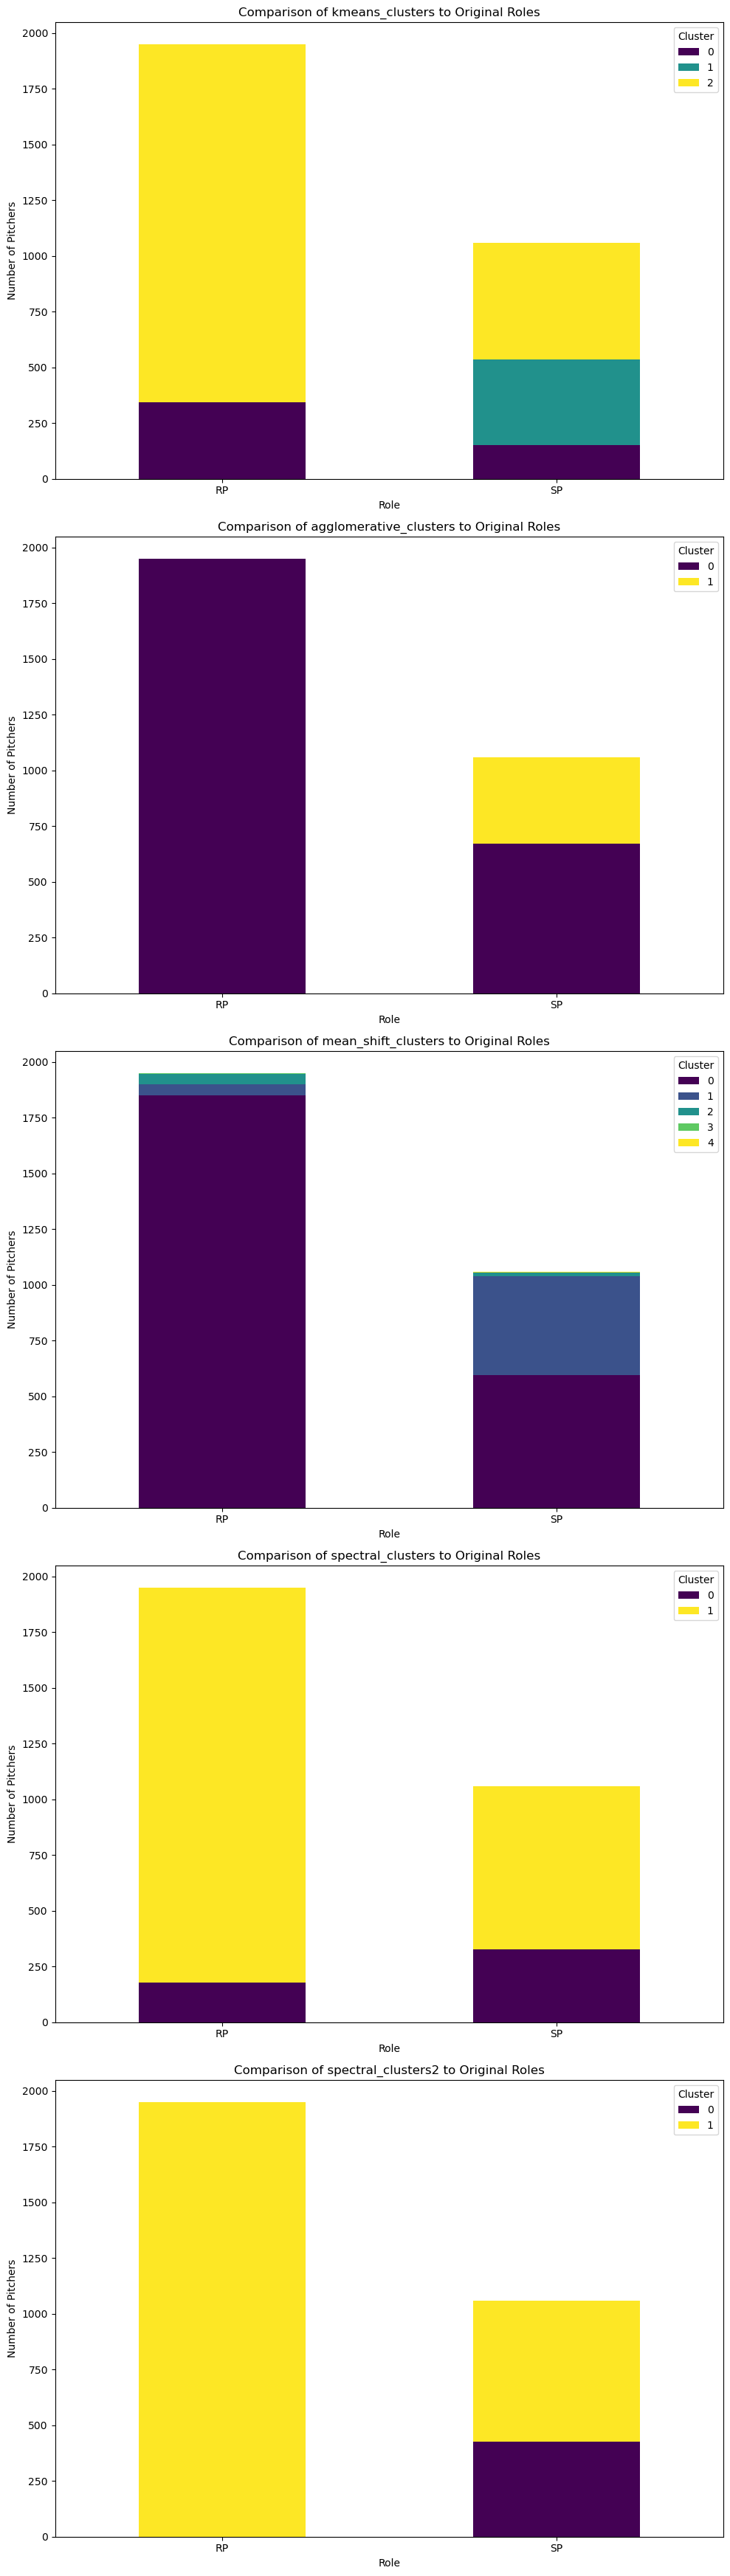

In [131]:
# Show clustering results

clustering_types = ['kmeans_clusters', 'agglomerative_clusters', 'mean_shift_clusters', 'spectral_clusters']
n_subplots = len(clustering_types)
fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(10, 7 * n_subplots))


for i, clustering_type in enumerate(clustering_types):
    comparison = pd.crosstab(mergedfgmets['Role'], mergedfgmets[clustering_type])
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, num=comparison.shape[1]))
    comparison.plot(kind='bar', stacked=True, ax=axes[i], color=colors)


    axes[i].set_title(f'Comparison of {clustering_type} to True Roles')
    axes[i].set_xlabel('Role')
    axes[i].set_ylabel('Number of Pitchers')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].legend(title='Cluster')


plt.tight_layout()
plt.show()

Assign clusters to roles based on occurences in each Role. Vote on the data points' assigned cluster based on majority vote

In [167]:
def assign_cluster_roles(df, cluster_col, true_role_col):
    cluster_roles = {}
    for cluster in df[cluster_col].unique():
        cluster_points = df[df[cluster_col] == cluster]
        role_counts = cluster_points[true_role_col].value_counts()
        # Assign the role with the majority count to the cluster
        majority_role = role_counts.idxmax()
        cluster_roles[cluster] = majority_role
    return cluster_roles
    
def map_clusters_to_roles(df, cluster_col, cluster_roles):
    df[cluster_col + '_role'] = df[cluster_col].map(cluster_roles)
    df[cluster_col + '_correct'] = df[cluster_col + '_role'] == df['Role']
    return df

def calculate_clustering_accuracy(df, cluster_col):
    accuracy = df[cluster_col + '_correct'].mean() * 100
    return accuracy

def plot_clustering_accuracy(df, clustering_cols):
    accuracies = [calculate_clustering_accuracy(df, col) for col in clustering_cols]
    plt.figure(figsize=(10, 6))
    plt.bar(clustering_cols, accuracies, color='skyblue')
    plt.xlabel('Clustering Type')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy of Clustering Types in Identifying Roles')
    plt.ylim(70,85)
    plt.xticks(rotation=45)
    plt.show()

clustering_types = ['kmeans_clusters', 'agglomerative_clusters', 'mean_shift_clusters', 'spectral_clusters']
for clustering_type in clustering_types:
    cluster_roles = assign_cluster_roles(mergedfgmets, clustering_type, 'Role')
    mergedfgmets = map_clusters_to_roles(mergedfgmets, clustering_type, cluster_roles)

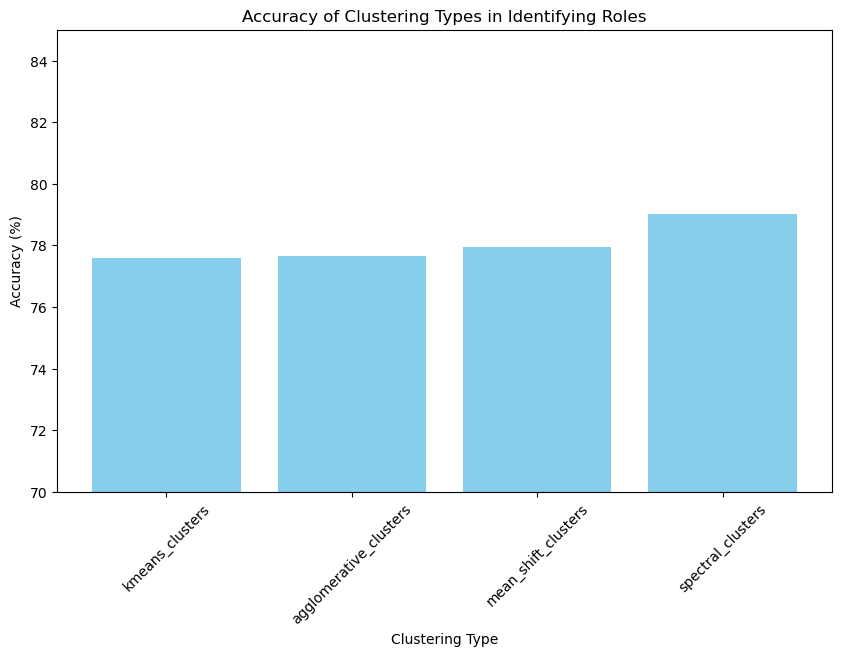

In [168]:
# Show which algorithm was most successful based on True Roles
plot_clustering_accuracy(mergedfgmets, clustering_types)

<Figure size 1000x1200 with 0 Axes>

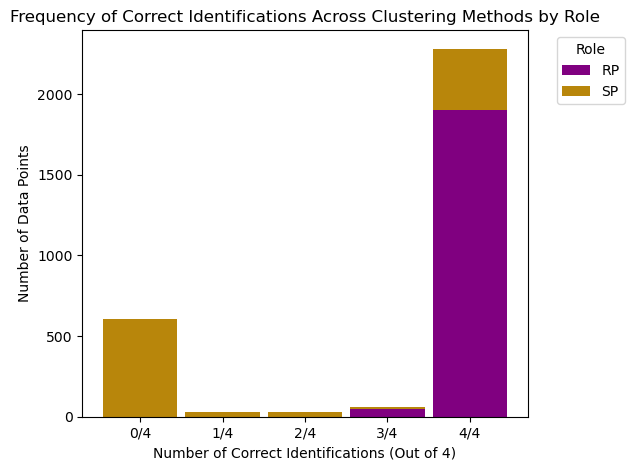

In [306]:
# Show how often each Role was clustered correctly vs incorrectly
correct_cols = ['kmeans_clusters_correct', 'agglomerative_clusters_correct', 'mean_shift_clusters_correct', 'spectral_clusters_correct']
mergedfgmets['correct_sum'] = mergedfgmets[correct_cols].sum(axis=1)
grouped_data = mergedfgmets.groupby(['correct_sum', 'Role']).size().unstack(fill_value=0)


custom_colors = {
    'SP': 'darkgoldenrod',
    'RP': 'purple'
}

role_colors = {role: custom_colors.get(role, np.random.rand(3,)) for role in grouped_data.columns}

# Plot
plt.figure(figsize=(10, 12))
grouped_data.plot(kind='bar', stacked=True, width=0.9, color=[role_colors[role] for role in grouped_data.columns])

plt.title('Frequency of Correct Identifications Across Clustering Methods by Role')
plt.xlabel('Number of Correct Identifications (Out of 4)')
plt.ylabel('Number of Data Points')
plt.xticks(ticks=range(len(grouped_data)), labels=['0/4', '1/4', '2/4', '3/4', '4/4'], rotation=0)
plt.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() 
plt.show()



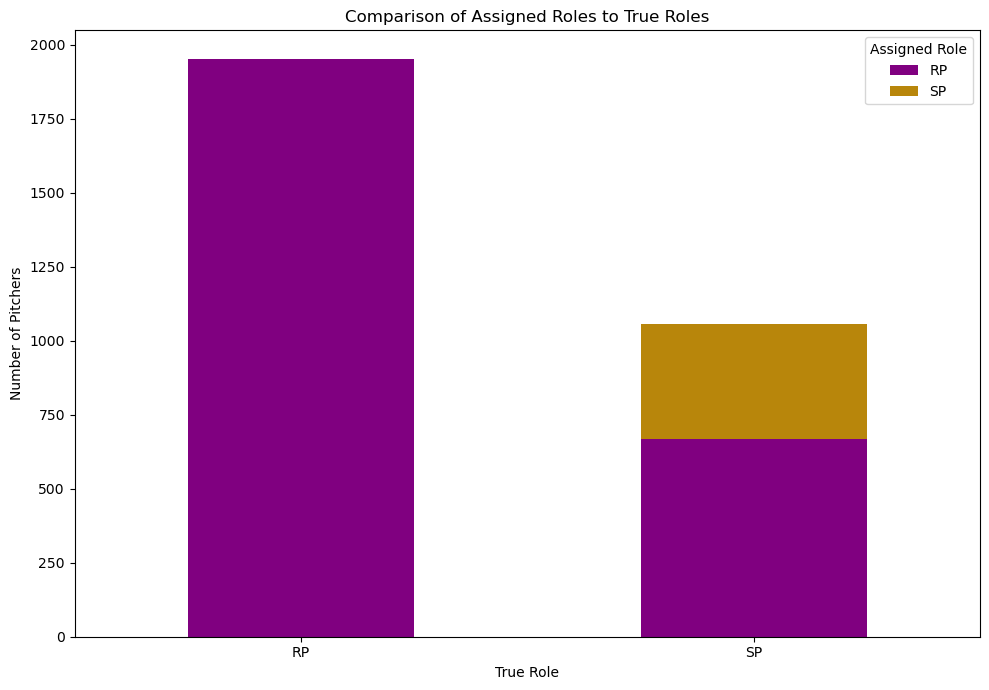

In [298]:
def assign_most_frequent_role(df, clustering_cols):
    roles_df = pd.DataFrame(index=df.index)
    for col in clustering_cols:
        role_col = col + '_role'
        roles_df[role_col] = df[role_col]
    
    # Determine the most frequent role across all clustering types for each data point
    df['assigned_role'] = roles_df.mode(axis=1)[0]  # [0] to select the first mode in case of ties
    return df

clustering_cols = ['kmeans_clusters', 'agglomerative_clusters', 'mean_shift_clusters', 'spectral_clusters']
mergedfgmets = assign_most_frequent_role(mergedfgmets, clustering_cols)
comparison_og = pd.crosstab(mergedfgmets['Role'], mergedfgmets['assigned_role'])
unique_roles = comparison_og.columns.tolist() 
color_map = {role: ('darkgoldenrod' if role == 'SP' else 'Purple' if role == 'RP' else np.random.rand(3,)) for role in unique_roles}  # Assign colors

# Generate colors list based on the order of roles in the dataframe
colors = [color_map[role] for role in comparison_og.columns]

# Plotting
comparison_og.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)

plt.title('Comparison of Assigned Roles to True Roles')
plt.xlabel('True Role')
plt.ylabel('Number of Pitchers')
plt.xticks(rotation=0)
plt.legend(title='Assigned Role')
plt.tight_layout()
plt.show()

### Take a closer look at pitchers who were incorrectly clustered by all algrithms:

In [181]:
incorrectly_identified_df = mergedfgmets[mergedfgmets['correct_sum'] == 0]
incorrectly_identified_df.Name.unique()

array(['Ervin Santana', 'Scott Kazmir', 'Jesse Chavez', 'Ross Detwiler',
       'Andrew Albers', 'Wade LeBlanc', 'David Price',
       'Jhoulys ChacÃ\xadn', 'Carlos Carrasco', 'Robert Stock',
       'Lucas Luetge', 'Craig Stammen', 'JosÃ© Quintana', 'Jose Alvarez',
       'Chris Archer', 'Paolo Espino', 'Trevor Cahill',
       'HÃ©ctor Santiago', 'Chase Anderson', 'Derek Holland',
       'Brad Peacock', 'Danny Duffy', 'Matt Moore', 'Jimmy Nelson',
       'Chris Sale', 'Julio Teheran', 'Humberto Castellanos',
       'Matt Shoemaker', 'Danny Coulombe', 'Collin McHugh',
       'Tommy Milone', 'Sean Nolin', 'Tanner Roark', 'Stephen Strasburg',
       'Louis Head', 'Cody Poteet', 'Andrew Kittredge', 'Matthew Boyd',
       'Mike Fiers', 'Seth Frankoff', 'Drew Hutchison', 'Aaron Loup',
       'Miles Mikolas', 'Pierce Johnson', 'JosÃ© De LeÃ³n',
       'Adrian Sampson', 'Aaron Sanchez', 'Caleb Smith',
       'Asher Wojciechowski', 'Mike Mayers', 'Jacob deGrom',
       'Daniel Ponce de Leon', '

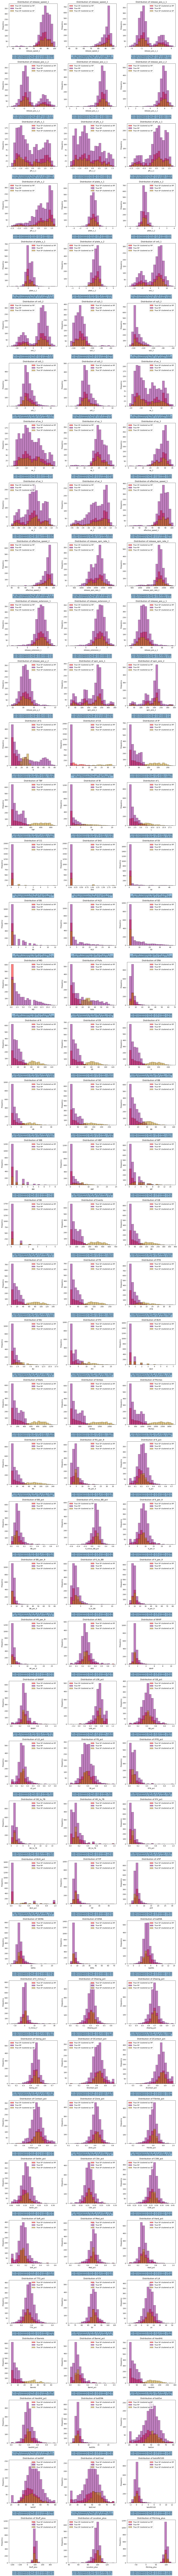

In [322]:
# Labelled relievers
labelled_relievers = mergedfgmets[mergedfgmets.Role == 'RP']
columns_to_exclude = ['Throws_L',	'Throws_R', 'Role',	'cluster',	'Name',	'dbscan_clu',	'kmeans_clusters',	'hdbscan_clusters',	'affinity_clusters',	'mean_shift_clusters',	'agglomerative_clusters',	'spectral_clusters',	'spectral_clusters2',	'kmeans_clusters_role',	'kmeans_clusters_correct',	'agglomerative_clusters_role',	'agglomerative_clusters_correct',	'mean_shift_clusters_role',	'mean_shift_clusters_correct',	'spectral_clusters_role',	'spectral_clusters_correct',	'assigned_role',	'correct_sum']  
columns_to_compare = [col for col in mergedfgmets.columns if col not in columns_to_exclude]

#plotting
n_cols = 3
n_rows = (len(columns_to_compare) + 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_compare):
    min_val = min(correctly_identified_df[column].min(), incorrectly_identified_df[column].min(), labelled_relievers[column].min())
    max_val = max(correctly_identified_df[column].max(), incorrectly_identified_df[column].max(), labelled_relievers[column].max())
    bins = np.linspace(min_val, max_val, 21)  # Define 20 bins between the min and max values

    # Plot histograms
    axes[i].hist(incorrectly_identified_df[column], bins=bins, alpha=0.5, label='True SP clustered as RP', color='red', edgecolor='black')
    axes[i].hist(labelled_relievers[column], bins=bins, alpha=0.5, label='True RP', color='purple', edgecolor='black')
    axes[i].hist(correctly_identified_df[column], bins=bins, alpha=0.5, label='True SP clustered as SP', color='darkgoldenrod', edgecolor='black')

    # Perform K-S tests
    ks_stat_correct, ks_p_value_correct = ks_2samp(incorrectly_identified_df[column], correctly_identified_df[column])
    ks_stat_incorrect, ks_p_value_incorrect = ks_2samp(incorrectly_identified_df[column], labelled_relievers[column])

    # Annotate K-S test results below the subplot
    annotation_text = f"K-S Stat (Compared to True SP): {ks_stat_correct:.2f}, p-value: {ks_p_value_correct:.2g}\n" \
                      f"K-S Stat (Compared to True RP): {ks_stat_incorrect:.2f}, p-value: {ks_p_value_incorrect:.2g}"
    axes[i].annotate(annotation_text, xy=(0.5, -0.2), xycoords='axes fraction', ha='center', va='top', fontsize=9, bbox=dict(boxstyle="round", alpha=0.5))

    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, n_cols * n_rows):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2)
plt.show()


### Argue some pitchers that we clustered as RP but are labelled as SP should be RP

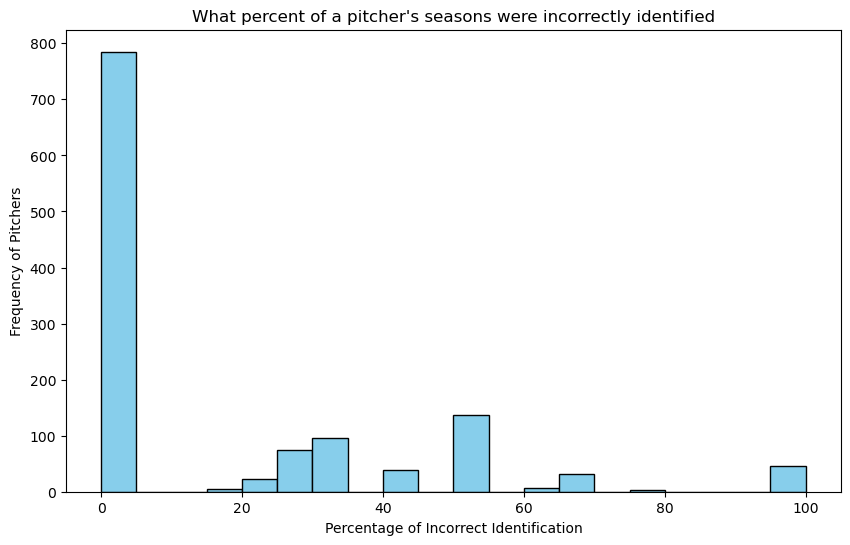

In [319]:
# Find percentage of player stats (i.e. seasons) that were misclustered
total_counts = mergedfgmets['Name'].value_counts()
incorrect_counts = incorrectly_identified_df['Name'].value_counts()
percentages = (incorrect_counts / total_counts).fillna(0) * 100
percentagesdf = percentages.reset_index()
percentagesdf.columns = ['Name', 'perc']
percentagesdf['TotalApp'] = percentagesdf['Name'].map(total_counts)

# plotting
plt.figure(figsize=(10, 6))
plt.hist(percentagesdf['perc'], bins=20, color='skyblue', edgecolor='black')
plt.title("What percent of a pitcher's seasons were incorrectly identified")
plt.xlabel('Percentage of Incorrect Identification')
plt.ylabel('Frequency of Pitchers')
plt.show()

There are only 3 seasons in our data, so anyone with over 3 season appearances (TotalApp column) has at least on season with a duplicate entry, meaning they were a SP and RP in a given season. We are dropping these pitchers from further analysis because they have already been played as RPs, but they can be shown below before we drop them

In [320]:
should_be_relievers = percentagesdf[percentagesdf['perc'] > 50]
pd.DataFrame(should_be_relievers).sort_values('TotalApp', ascending = False).head(9)

,Name,perc,TotalApp
787,Luis PatiÃ±o,60.0,5
983,Roansy Contreras,60.0,5
1130,Touki Toussaint,60.0,5
1112,Thomas Hatch,60.0,5
1018,Ryan Weathers,60.0,5
264,Connor Overton,60.0,5
82,Angel Zerpa,75.0,4
749,Kyle Muller,75.0,4
545,Janson Junk,75.0,4


In [282]:
# Ignore players that have ony pitched in one season, and ignore players that have both started and relieved in a given season:
contenders = should_be_relievers[(should_be_relievers.TotalApp > 1) & (should_be_relievers.TotalApp <= 3)]
# rank by how much we think they should be RPs, we want them to have multiple seasons of data, with the highest percentage of RP clusterings
contenders = contenders.sort_values(["perc", "TotalApp"], ascending=False)
contenders.head(40)

,Name,perc,TotalApp
361,Dustin May,100.000000,3
686,Justin Dunn,100.000000,2
782,Luis Gil,100.000000,2
1056,Shane Baz,100.000000,2
1076,Spencer Turnbull,100.000000,2
1082,Stephen Strasburg,100.000000,2
1121,Tommy Henry,100.000000,2
31,AdriÃ¡n MartÃ­nez,66.666667,3
45,Alex Faedo,66.666667,3
189,Caleb Kilian,66.666667,3


The Starters who we believe should be Relievers are: Dustin May, Justing Dunn, Shane Baz, Jacob deGrom, and their stats are shown below.

In [287]:
best_cases = mergedfgmets[(mergedfgmets.Name == "Dustin May") | (mergedfgmets.Name == "Justin Dunn") | (mergedfgmets.Name == "Shane Baz") | (mergedfgmets.Name == "Jacob deGrom")]
best_cases.head(25)

cols_to_keep = ['Name', 'Role', 'assigned_role', 'IP', 'Pitching_plus', 'FStrike_pct', 'WHIP', 'AVG', 'H_per_9', 'K_per_9', 'BB_per_9', 'K_pct', 'BB_pct', 'Pitches', 'ERA']
best_cases = best_cases.loc[:, cols_to_keep]
best_cases.sort_values('Name').head(20)

,Name,Role,assigned_role,IP,Pitching_plus,FStrike_pct,WHIP,AVG,H_per_9,K_per_9,BB_per_9,K_pct,BB_pct,Pitches,ERA
917,Dustin May,SP,RP,23.0,112.518852,0.6344,0.956522,0.186047,6.260870,13.695652,2.347826,0.3763,0.0645,368,2.739130
1834,Dustin May,SP,RP,30.0,100.921730,0.5906,1.166667,0.194444,6.300000,8.700000,4.200000,0.2283,0.1102,474,4.500000
2719,Dustin May,SP,RP,48.0,108.820194,0.5989,0.937500,0.171598,5.437500,6.375000,3.000000,0.1818,0.0856,736,2.625000
318,Jacob deGrom,SP,RP,92.0,117.974062,0.6296,0.554348,0.128205,3.913043,14.282609,1.076087,0.4506,0.0340,1226,1.076087
1254,Jacob deGrom,SP,RP,64.1,117.077553,0.6987,0.746114,0.173160,5.595858,14.269438,1.119172,0.4268,0.0335,940,3.077722
2185,Jacob deGrom,SP,RP,30.1,116.564745,0.6609,0.758243,0.171171,5.637369,13.351663,1.186815,0.3913,0.0348,451,2.670333
643,Justin Dunn,SP,RP,50.1,102.124281,0.5550,1.311259,0.200000,6.615898,8.761595,5.185434,0.2248,0.1330,870,3.754969
1526,Justin Dunn,SP,RP,31.0,89.534615,0.5652,1.580645,0.271186,9.290323,6.096774,4.935484,0.1522,0.1232,540,6.096774
929,Shane Baz,SP,RP,13.1,114.039394,0.5306,0.675002,0.130435,4.050010,12.150031,2.025005,0.3673,0.0612,198,2.025005
1846,Shane Baz,SP,RP,27.0,103.600452,0.5897,1.333333,0.252336,9.000000,10.000000,3.000000,0.2564,0.0769,444,5.000000


### Appendix:

-Parameter searches for clustering algorithms

In [68]:
def evaluate_kmeans(X, true_labels, n_clusters_range):
    best_ari = -1
    best_n_clusters = None

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        predicted_labels = kmeans.fit_predict(X)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        if ari > best_ari:
            best_ari = ari
            best_n_clusters = n_clusters

    return best_n_clusters, best_ari

n_clusters_range = range(2, 4)  
best_n_clusters, best_ari = evaluate_kmeans(X_encoded, mergedfgmets['Role'], n_clusters_range)
print(f"Best ARI for KMeans: {best_ari} with n_clusters: {best_n_clusters}")


/Users/eha0927/opt/anaconda3/envs/DL_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/eha0927/opt/anaconda3/envs/DL_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Best ARI for KMeans: 0.09793591926727382 with n_clusters: 3


In [69]:

def evaluate_hdbscan(X, true_labels, min_cluster_sizes, min_samples_list, alpha_list, cluster_selection_epsilon_list, cluster_selection_method_list, allow_single_cluster_list):
    best_ari = -1
    best_params = {}

    # Generate all combinations of parameters to be evaluated
    parameter_combinations = itertools.product(min_cluster_sizes, min_samples_list, alpha_list, cluster_selection_epsilon_list, cluster_selection_method_list, allow_single_cluster_list)

    for min_cluster_size, min_samples, alpha, cluster_selection_epsilon, cluster_selection_method, allow_single_cluster in parameter_combinations:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    alpha=alpha,
                                    cluster_selection_epsilon=cluster_selection_epsilon,
                                    cluster_selection_method=cluster_selection_method,
                                    allow_single_cluster=allow_single_cluster,
                                    gen_min_span_tree=False)
        clusterer.fit(X)
        predicted_labels = clusterer.labels_
        
        # Only evaluate if we have more than one cluster (excluding noise)
        if len(set(predicted_labels)) - (1 if -1 in predicted_labels else 0) > 1:
            ari = adjusted_rand_score(true_labels, predicted_labels)

            if ari > best_ari:
                best_ari = ari
                best_params = {
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples,
                    'alpha': alpha,
                    'cluster_selection_epsilon': cluster_selection_epsilon,
                    'cluster_selection_method': cluster_selection_method,
                    'allow_single_cluster': allow_single_cluster
                }

    return best_params, best_ari

min_cluster_sizes = range(2, 4)  
min_samples_list = [1, 5, 10]  
alpha_list = [0.5, 1.0, 1.5]  
cluster_selection_epsilon_list = [0.0, 0.5, 1.0]  
cluster_selection_method_list = ['eom', 'leaf']  #
allow_single_cluster_list = [False]  

best_params, best_ari = evaluate_hdbscan(X_encoded, mergedfgmets['Role'], min_cluster_sizes, min_samples_list, alpha_list, cluster_selection_epsilon_list, cluster_selection_method_list, allow_single_cluster_list)
print(f"Best ARI for HDBSCAN: {best_ari} with parameters: {best_params}")

Best ARI for HDBSCAN: 0.0373146339292399 with parameters: {'min_cluster_size': 3, 'min_samples': 1, 'alpha': 0.5, 'cluster_selection_epsilon': 0.0, 'cluster_selection_method': 'leaf', 'allow_single_cluster': False}


In [70]:
def evaluate_affinity_propagation(X, true_labels):
    preferences = [np.median(X), np.mean(X)]
    best_ari = -1
    best_preference = None

    for preference in preferences:
        clustering = AffinityPropagation(preference=preference, random_state=42)
        predicted_labels = clustering.fit_predict(X)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        if ari > best_ari:
            best_ari = ari
            best_preference = preference

    return best_preference, best_ari

best_preference, best_ari = evaluate_affinity_propagation(X_encoded, mergedfgmets['Role'])
print(f"Best ARI for Affinity Propagation: {best_ari} with preference: {best_preference}")


Best ARI for Affinity Propagation: 0.0 with preference: 8.667573928833008


In [80]:
def evaluate_mean_shift(X, true_labels, quantiles):
    best_ari = -1
    best_quantile = None

    for quantile in quantiles:
        bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=500)
        clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        predicted_labels = clustering.fit_predict(X)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        if ari > best_ari:
            best_ari = ari
            best_quantile = quantile

    return best_quantile, best_ari

quantiles = np.linspace(.25, .5, 5)  
best_quantile, best_ari = evaluate_mean_shift(X_encoded, mergedfgmets['Role'], quantiles)
print(f"Best ARI for Mean Shift: {best_ari} with quantile: {best_quantile}")


Best ARI for Mean Shift: 0.0 with quantile: 0.25
